In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import statsmodels.formula.api as smf
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
import matplotlib.pyplot as plt
# from google.colab import drive
# drive.mount('/content/drive')
import re
def tablelize(star):
    string = star.render_latex().replace("\\begin{table}[!htbp] \\centering","").replace("\\end{table}","").replace("_","\\_")
    return re.sub(r"\(df=[\d; ]*\)", "", string)

<Axes: xlabel='distance', ylabel='Count'>

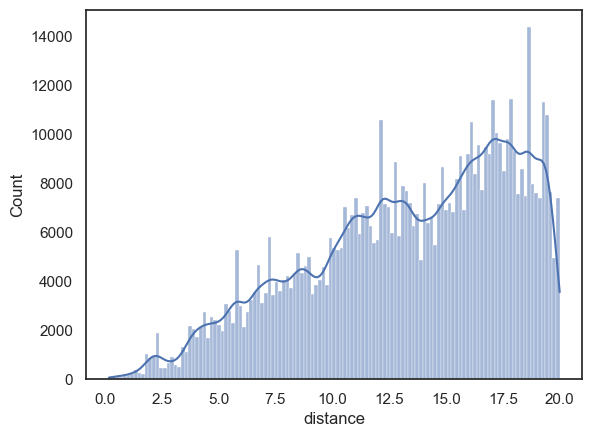

In [2]:
log=np.log
sns.set_theme(style="white")
original_df = pd.read_parquet("../data/olsupsnew.parquet")
sns.histplot(original_df["distance"], kde=True)

In [3]:
df = original_df[original_df["保险金额"] > 0].copy()
df["历史投保"] = df["上年保单号"].map(lambda x: 1 if x else 0)
df = df[(df["t"] > 1999) & (df["t"] < 2014)]
df["ti"] = (df["t"]-2000).astype(str)
df["是否理赔"] = df["total_claim"].map(lambda x: 1 if x > 0 else 0)

df.rename(
    columns={
        "保费合计": "Premium",
        "保险金额": "Coverage",
        "middle": "Neighbor",
        "treated": "Disaster",
        "after": "Post",
        "历史投保": "Prem_before",
        "保险财产购置价": "Price",
        "建筑面积": "Area",
        "是否理赔":"Claim",
        "保险密度": "Density",
        "保险深度": "Penetration",
        "gdp": "GDP"
    },
    inplace=True,
)
df["Price"]=df["Price"]/10000
columns = ['Premium', 'Coverage', 'Price', 'Density', 'Penetration', 'GDP']
minmax=[0.025,0.975]
quantiles=df[columns].quantile(minmax)
for column in columns:
    df=df[(df[column]>quantiles.loc[minmax[0], column]) & (df[column]<quantiles.loc[minmax[1], column])]
df=df[df["Price"]>0]
df=df.copy()
# df.to_parquet("../data/df1.parquet")
df.head()

,省份,站名,minpost,maxpost,total_claim,下年保单号,Neighbor,区站号,区站经度,区站纬度,...,Premium,Price,Area,t,GDP,Density,Penetration,Prem_before,ti,Claim
1,广东,广州,217.0,-113.0,0.0,,0,59287,113.19,23.08,...,1950.000000,55.995800,104.910004,2004,0.190599,163.334050,0.797542,0,4,0
3,四川,都江堰,0.0,0.0,0.0,,0,56188,103.40,30.59,...,929.880005,21.500000,215.000000,2004,0.196235,59.332509,0.761426,0,4,0
4,四川,都江堰,0.0,0.0,0.0,,0,56188,103.40,30.59,...,874.799988,21.500000,215.000000,2004,0.196235,59.332509,0.761426,0,4,0
5,四川,都江堰,0.0,0.0,0.0,,0,56188,103.40,30.59,...,1093.500000,21.500000,45.000000,2004,0.196235,59.332509,0.761426,0,4,0
6,四川,都江堰,0.0,0.0,0.0,,0,56188,103.40,30.59,...,3207.600098,63.747601,144.029999,2004,0.196235,59.332509,0.761426,0,4,0


## DID 回归

### 远vs中

In [4]:
model1 = smf.ols("log(Coverage) ~ Neighbor*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)+C(ti)", data=df[(df["Disaster"]==0)]).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log(Coverage)   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     8015.
Date:                Sat, 18 May 2024   Prob (F-statistic):               0.00
Time:                        19:25:52   Log-Likelihood:            -2.7386e+05
No. Observations:              259132   AIC:                         5.478e+05
Df Residuals:                  259111   BIC:                         5.480e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           11.1128      0.123     90.688      0.000      10.873      11.353
C(ti)[T.1]          -0.1341      0.132     -1.014      0.311      -0.394       0.125
C(ti)[T.10]         -0.1259      0.121     -1.037      0.300      -0.364       0.112
C(ti)[T.11]         -0.0959      0.121     -0.790      0.430      -0.334       0.142
C(ti)[T.12]         -0.2296      0.121     -1.891      0.059      -0.467       0.008
C(ti)[T.13]          0.4229      0.125      3.371      0.001       0.177       0.669
C(ti)[T.2]          -0.0762      0.126     -0.607      0.544      -0.322       0.170
C(ti)[T.3]          -0.0779      0.121     -0.642      0.521      -0.316       0.160
C(ti)[T.4]          -0.2742      0.121     -2.261      0.024      -0.512      -0.036
C(ti)[T.5]          -0.3308      0.121     -2.728      0.006      -0.568      -0.093
C(ti)[T.6]          -0.3352      0.121     -2.764      0.006      -0.573      -0.097
C(ti)[T.7]          -0.2588      0.121     -2.133      0.033      -0.497      -0.021
C(ti)[T.8]          -0.1672      0.121     -1.378      0.168      -0.405       0.071
C(ti)[T.9]          -0.3357      0.121     -2.767      0.006      -0.574      -0.098
Neighbor            -0.2610      0.019    -13.831      0.000      -0.298      -0.224
Post                 0.1175      0.005     23.846      0.000       0.108       0.127
Neighbor:Post        0.2474      0.020     12.562      0.000       0.209       0.286
Prem_before          0.2053      0.007     29.092      0.000       0.192       0.219
log(Price)           0.3435      0.001    314.760      0.000       0.341       0.346
log(Penetration)     0.6890      0.007     93.335      0.000       0.675       0.703
log(GDP)            -0.1536      0.009    -17.784      0.000      -0.171      -0.137
==============================================================================
Omnibus:                   119300.204   Durbin-Watson:                   1.205
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1815385.399
Skew:                           1.827   Prob(JB):                         0.00
Kurtosis:                      15.441   Cond. No.                     1.44e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
raws1 = smf.ols("log(Coverage) ~ Neighbor*Post+C(ti)", data=df[(df["Disaster"]==0)]).fit()
stargazer = Stargazer([raws1, model1])
stargazer


In [21]:
with open("../lib/table/did1.tex", "w") as f:
    f.write(tablelize(stargazer))

### 远vs近

In [22]:
model2 = smf.ols("log(Coverage) ~ Disaster*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)+C(ti)", data=df[(df["Neighbor"]==0)]).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log(Coverage)   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     9815.
Date:                Sat, 18 May 2024   Prob (F-statistic):               0.00
Time:                        19:21:35   Log-Likelihood:            -2.9358e+05
No. Observations:              285872   AIC:                         5.872e+05
Df Residuals:                  285851   BIC:                         5.874e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           11.4596      0.093    123.674      0.000      11.278      11.641
C(ti)[T.1]          -0.4078      0.100     -4.058      0.000      -0.605      -0.211
C(ti)[T.10]         -0.4684      0.091     -5.130      0.000      -0.647      -0.289
C(ti)[T.11]         -0.4371      0.091     -4.789      0.000      -0.616      -0.258
C(ti)[T.12]         -0.5136      0.091     -5.624      0.000      -0.693      -0.335
C(ti)[T.13]          0.0968      0.096      1.005      0.315      -0.092       0.286
C(ti)[T.2]          -0.4041      0.096     -4.226      0.000      -0.591      -0.217
C(ti)[T.3]          -0.3984      0.091     -4.365      0.000      -0.577      -0.219
C(ti)[T.4]          -0.6120      0.091     -6.709      0.000      -0.791      -0.433
C(ti)[T.5]          -0.6583      0.091     -7.217      0.000      -0.837      -0.479
C(ti)[T.6]          -0.6469      0.091     -7.093      0.000      -0.826      -0.468
C(ti)[T.7]          -0.5768      0.091     -6.322      0.000      -0.756      -0.398
C(ti)[T.8]          -0.5007      0.091     -5.486      0.000      -0.680      -0.322
C(ti)[T.9]          -0.6004      0.091     -6.578      0.000      -0.779      -0.421
Disaster            -0.0076      0.007     -1.101      0.271      -0.021       0.006
Post                 0.1133      0.005     23.692      0.000       0.104       0.123
Disaster:Post       -0.1873      0.008    -22.831      0.000      -0.203      -0.171
Prem_before          0.2143      0.007     30.495      0.000       0.201       0.228
log(Price)           0.3645      0.001    348.252      0.000       0.362       0.367
log(Penetration)     0.6994      0.007    103.013      0.000       0.686       0.713
log(GDP)            -0.1019      0.008    -12.708      0.000      -0.118      -0.086
==============================================================================
Omnibus:                   146847.026   Durbin-Watson:                   1.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2943281.688
Skew:                           2.024   Prob(JB):                         0.00
Kurtosis:                      18.189   Cond. No.                     1.17e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
raws2 = smf.ols("log(Coverage) ~ Disaster*Post+C(ti)", data=df[(df["Neighbor"]==0)]).fit()
stargazer = Stargazer([raws2, model2])
stargazer


In [24]:
with open("../lib/table/did2.tex", "w") as f:
    f.write(tablelize(stargazer))

## 进一步分析

In [25]:
df["claimed"]=df["total_claim"].map(lambda x: 1 if x>0 else 0)
claims = smf.logit("claimed ~ log(Coverage)+Disaster*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=df[(df["Neighbor"]==0)]).fit()
rawsclaim = smf.logit("claimed ~ Disaster*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=df[(df["Neighbor"]==0)]).fit()
stargazer = Stargazer([rawsclaim, claims])
# with open("../lib/table/claims.tex", "w") as f:
#     f.write(tablelize(stargazer))
stargazer
# claims.summary()

Optimization terminated successfully.
         Current function value: 0.009556
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.009563
         Iterations 13


In [27]:
treated = df[df["Neighbor"]==0].copy()
treated["renew"]=treated["下年保单号"].map(lambda x: 1 if x else 0)
renew = smf.logit("renew ~ log(Coverage)+Disaster*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=treated).fit()
rawsrenew = smf.logit("renew  ~ Disaster*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=treated).fit()
stargazer = Stargazer([rawsclaim,claims,rawsrenew, renew])
stargazer.custom_columns(['Claim', 'Claim', "Renew", "Renew"])
with open("../lib/table/renew.tex", "w") as f:
    f.write(tablelize(stargazer))
stargazer
# claims.summary()

Optimization terminated successfully.
         Current function value: 0.091181
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.092431
         Iterations 11


## 稳健性测试

In [14]:
# def robust_test(category="Disaster", cond=False):
#     df["treated"]=df[category]
#     df["Quarter_before"] = df["maxpost"].map(
#         lambda x: x // 90  if (x < 0 and x > -365) else None
#     )
#     df["Quarter_after"] = df["minpost"].map(
#         lambda x: x // 90 if (x > 0 and x < 365) else None
#     )
#     if category == "Disaster":
#         df["Quarter_before"] = df["Quarter_after"].fillna(
#             (
#                 pd.to_datetime(df["maxraining_after"])
#                 - pd.to_datetime(df["保险起期"], unit="s")
#             ).dt.days.map(lambda x: x // 90 if (x <= 365 and x >= 0) else None)
#         )
#         df["Quarter_after"] = df["Quarter_before"].fillna(
#             -(
#                 pd.to_datetime(df["保险起期"], unit="s")
#                 - pd.to_datetime(df["maxraining_before"])
#             ).dt.days.map(lambda x: x // 90  if (x <= 365 and x > 0) else None)
#         )
#     df["Quarter"] = df["Quarter_before"].fillna(df["Quarter_after"])
#     y = -4 if category == "Disaster" else -3
#     data = df[df["Quarter"].between(y, 0)].copy()
#     reg_str = "log(Coverage) ~ treated*C(Quarter)"
#     if cond:
#         reg_str += "+Prem_before+Price+Area"
#     model = smf.ols(
#         reg_str,
#         data=data,
#     ).fit()
#     robust=df[["Disaster","Neighbor", "Quarter", "Coverage"]]
#     robust.to_parquet(f"../data/robust_{category}.parquet")
#     return model


# stargazer = Stargazer(
#     [robust_test(i, j) for i in ["Disaster", "Neighbor"] for j in [False, True]]
# )
# # stargazer.custom_columns(["Disaster", "Disaster", "Neighbor", "Neighbor"])
# # with open("../lib/table/robust.tex", "w") as f:
# #     f.write(tablelize(stargazer))
# stargazer

In [14]:
df["Pre"]=df["Disaster"]*((pd.to_datetime(df['record_date'])-pd.to_datetime(df['保险起期']))).dt.days//90+(df["maxpost"]//90)
# df["Pre"]=df["Pre"].map(lambda x: 1 if x>=-4 and x<0 else 0)
# df["After"]=1-df["Pre"]
stars=[]
for category in ["Disaster","Neighbor"]:
    noncat = "Disaster" if category=="Neighbor" else "Neighbor"
    for post in ["", "Post"]:
        if not post:
            regstr = f"log(Coverage) ~ {category}*C(Pre)+Prem_before+log(Price)+log(GDP)+(Penetration)"
        else:
            regstr = f"log(Coverage) ~ {category}*C(Pre)+{category}*Post+Prem_before+log(Price)+(GDP)+log(Penetration)"
        model = smf.ols(regstr,data=df[(df[noncat]==0)&(df["Post"]==1)]).fit()
        stars.append(model)
stargazer=Stargazer(stars)
# with open("../lib/table/robust.tex", "w") as f:
#     f.write(tablelize(stargazer))
stargazer

## 异质性分析

In [5]:
# 分东中西部

hdf=df.copy()
east ={i:"East" for i in "北京、天津、河北、上海、江苏、浙江、福建、山东、广东、辽宁、海南".split("、")}
middle ={i:"West" for i in "山西、吉林、黑龙江、安徽、江西、河南、湖北、湖南".split("、")}
west ={i:"Middle" for i in "重庆、四川、内蒙古、广西、贵州、云南、西藏、陕西、甘肃、青海、宁夏、新疆".split("、")}
northeast ={i:"NorthEast" for i in "".split("、")}
provinces = {**east,**middle,**west,**northeast}
hdf["region"]=hdf["省份"].map(provinces)
stars = []
column = []
col=[]
for region, region_df in hdf.groupby("region"):
    column.append(region)
    col.append("Disaster")
    model = smf.ols("log(Coverage) ~ Disaster*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=region_df[region_df["Neighbor"]==0]).fit()
    # model = smf.ols("log(Coverage) ~ Neighbor*Post", data=region_df[region_df["Disaster"]==0]).fit()
    stars.append(model)
stargazer = Stargazer(stars)
stargazer

In [6]:
# stars = []
# column = []
for region, region_df in hdf.groupby("region"):
    column.append(region)
    col.append("Neighbor")
    # model = smf.ols("log(Coverage) ~ Disaster*Post+Prem_before+Price+Area", data=region_df[region_df["Neighbor"]==0]).fit()
    model = smf.ols("log(Coverage) ~ Neighbor*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=region_df[region_df["Disaster"]==0]).fit()
    stars.append(model)
stargazer = Stargazer(stars)
stargazer.custom_columns(column)
# stargazer.add_line("Region", column, "bt")
# stargazer.add_line("Treated", col, "bt")
with open("../lib/table/het_geo.tex", "w") as f:
    f.write(tablelize(stargazer))
stargazer

In [12]:
hdf=df.copy()
hdf = hdf[(hdf["t"]>2002)&(hdf["t"]<2013)]
stars = []
column = []
col = []
hdf["ti"]=hdf["t"].apply(lambda t: "2008-2013" if t>2007 else "2003-2007")
for region, region_df in hdf.groupby("ti"):
    column.append(region)
    col.append("Disaster")
    model = smf.ols("log(Coverage) ~ Disaster*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=region_df[region_df["Neighbor"]==0]).fit()
    # model = smf.ols("log(Coverage) ~ Neighbor*Post", data=region_df[region_df["Disaster"]==0]).fit()
    stars.append(model)
stargazer = Stargazer(stars)
# stargazer.custom_columns(column)
with open("../lib/table/het_time.tex", "w") as f:
    f.write(tablelize(stargazer))
stargazer

In [13]:
# stars = []
# column = []
hdf["ti"]=hdf["t"].apply(lambda t: "2008-2013" if t>2007 else "2003-2007")
for region, region_df in hdf.groupby("ti"):
    column.append(region)
    col.append("Neighbor")
    # model = smf.ols("log(Coverage) ~ Disaster*Post", data=region_df[region_df["Neighbor"]==0]).fit()
    model = smf.ols("log(Coverage) ~ Neighbor*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=region_df[region_df["Disaster"]==0]).fit()
    stars.append(model)
stargazer = Stargazer(stars)
stargazer.custom_columns(column)
with open("../lib/table/het_time.tex", "w") as f:
    f.write(tablelize(stargazer))
stargazer

In [11]:
stars = []
column = []
for region, region_df in df.groupby("t"):
    column.append(region)
    # model = smf.ols("log(Coverage) ~ Disaster*Post", data=region_df[region_df["Neighbor"]==0]).fit()
    model = smf.ols("log(Coverage) ~ Neighbor*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)", data=region_df[region_df["Disaster"]==0]).fit()
    stars.append(model)
stargazer = Stargazer(stars)
stargazer.custom_columns(column)
# with open("../lib/table/het_time.tex", "w") as f:
#     f.write(tablelize(stargazer))
stargazer

In [14]:
groups = "Coverage"
hdf = df[df[groups] > 0]
quantiles = hdf[groups].quantile([0.00, 0.35, 0.65, 1]).values.tolist()
hdf = hdf[hdf[groups].between(quantiles[0], quantiles[-1])]
stars = []

for category in ["Disaster", "Neighbor"]:
    for i in range(len(quantiles) - 1):
        noncat = "Neighbor" if category == "Disaster" else "Disaster"
        model = smf.ols(
            f"log(Coverage) ~ {category}*Post+Prem_before+log(Price)+log(Penetration)+log(GDP)",
            data=hdf[
                (hdf[groups].between(quantiles[i], quantiles[i + 1]))
                & (hdf[noncat] == 0)
            ],
        ).fit()
        stars.append(model)
stargazer = Stargazer(stars)
stargazer.custom_columns(["low", "mid", "high"]*2)
stargazer

In [30]:
with open("../lib/table/het_cov.tex", "w") as f:
    f.write(tablelize(stargazer))